In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AnálisisDeDatos/DataSets/Online Retail.csv", encoding='unicode_escape')
df.head()

,ï»¿InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ï»¿InvoiceNo  541909 non-null  object 
 1   StockCode     541909 non-null  object 
 2   Description   540455 non-null  object 
 3   Quantity      541909 non-null  int64  
 4   InvoiceDate   541909 non-null  object 
 5   UnitPrice     541909 non-null  float64
 6   CustomerID    406829 non-null  float64
 7   Country       541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df = df.rename(columns={'ï»¿InvoiceNo': 'InvoiceNo'})

In [5]:
df[df.columns].nunique()

,0
InvoiceNo,25900
StockCode,4070
Description,4223
Quantity,722
InvoiceDate,23260
UnitPrice,1630
CustomerID,4372
Country,38


## Limpieza de datos

In [6]:
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [7]:
df.dropna(subset='CustomerID',inplace=True)

df.shape

(406829, 8)

Ahora revizemos si hay duplicados y eliminemos los duplicados

In [8]:
df.duplicated().sum()

np.int64(5225)

In [9]:
df.drop_duplicates(keep='last', inplace=True)

Habían 5225 registros duplicados, los cuales fueron eliminados.

Verifiquemos ahora si existe información que no sea consistente o sea incorrecta. Ya sea por errores de captura o de comunicación.

In [10]:
df[['Quantity', 'UnitPrice']].agg({
    'Quantity': ['min', 'mean', 'max'],
    'UnitPrice': ['min', 'mean', 'max']
})

,Quantity,UnitPrice
min,-80995.000000,0.000000
mean,12.183273,3.474064
max,80995.000000,38970.000000


Observamos que existen valores negaticos en Quantity, cosa que podría ser asociado a devoluciones de algún producto vendido. Además observamos precios unitarios de $0, cosa que tampoco deberíamos tener.

Lo siguiente será eliminar los registros con cantidades de ventas negativas y con precios unitarios cero

In [11]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

## Manipulación de los Datos

Crearemos la tabla para la realización de nuestro análisis RFM, además una columna adicional para el componente monetario (SumTotal).


* SumTotal: Quantity x UnitPrice, representa el valor de cada línea de compra.

* Reency: Número de días desde la última compra del cliente hasta la fecha actual.

* Frequency: Número de facturas únicas por cliente (InvoiceNo diferentes)

* Monetary: Suma total gastada por cliente.


In [12]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d/%m/%Y %H:%M')
df['SumTotal'] = df['Quantity'] * df['UnitPrice']

recency_df = (df['InvoiceDate'].max() - df.groupby('CustomerID')['InvoiceDate'].max()).dt.days
frequency_df = df.groupby('CustomerID')['InvoiceNo'].nunique()
monetary_df = df.groupby('CustomerID')['SumTotal'].sum()

final_df = pd.merge(recency_df, frequency_df, on = 'CustomerID', how = 'inner')
final_df = pd.merge(final_df, monetary_df, on = 'CustomerID', how = 'inner')

final_df.rename(columns = {'InvoiceDate':'Recency',
                           'InvoiceNo':'Frequency',
                           'SumTotal':'Monetary'},
                           inplace = True)
final_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,1,7,4310.00
12348.0,74,4,1797.24
12349.0,18,1,1757.55
12350.0,309,1,334.40


Obtengamos algunos estadísticos:

In [13]:
round(final_df.describe(),2)

,Recency,Frequency,Monetary
count,4338.00,4338.00,4338.00
mean,91.54,4.27,2048.69
std,100.01,7.70,8985.23
min,0.00,1.00,3.75
25%,17.00,1.00,306.48
50%,50.00,2.00,668.57
75%,141.00,5.00,1660.60
max,373.00,209.00,280206.02


**Días desde la última compra**:
* El intervalo de tiempo entre los clientes que más y menos tiempo tardan en comprar es de poco más de un año.
* En promedio un cliente tarda 3 meses para realizar una compra
* El 50% de los clientes tarda 2 meses en realizar una compra.

Las estadísticas indican una buena captación de atención de los clientes.

** Número de facturas únicas**
* En promedio un cliente realiza 4 compras en un periodo de un año. Con un promedio de 3 meses entre compras.
* El cliente con más compras realizó 209 compras en un año. Posiblemente tratándose de un revendedor o un cliente mayorista.

**Total Gastado**
* El ticket promedio de compra es de \$ 2048.69. Los valores varían entre \$3.75 y \$280206.02.
* La fuerte diferencia entre media y mediana en Monetary indica asimetría positiva, lo que sugiere que unos pocos clientes gastan mucho más que el resto. Esto confirma la conveniencia de segmentar a los clientes en lugar de tratarlos como un conjunto homogéneo.

Haremos uso de gráficos de barras para observar la distribución de los datos, podremos así detectar asimetrías, valores extremos etc.

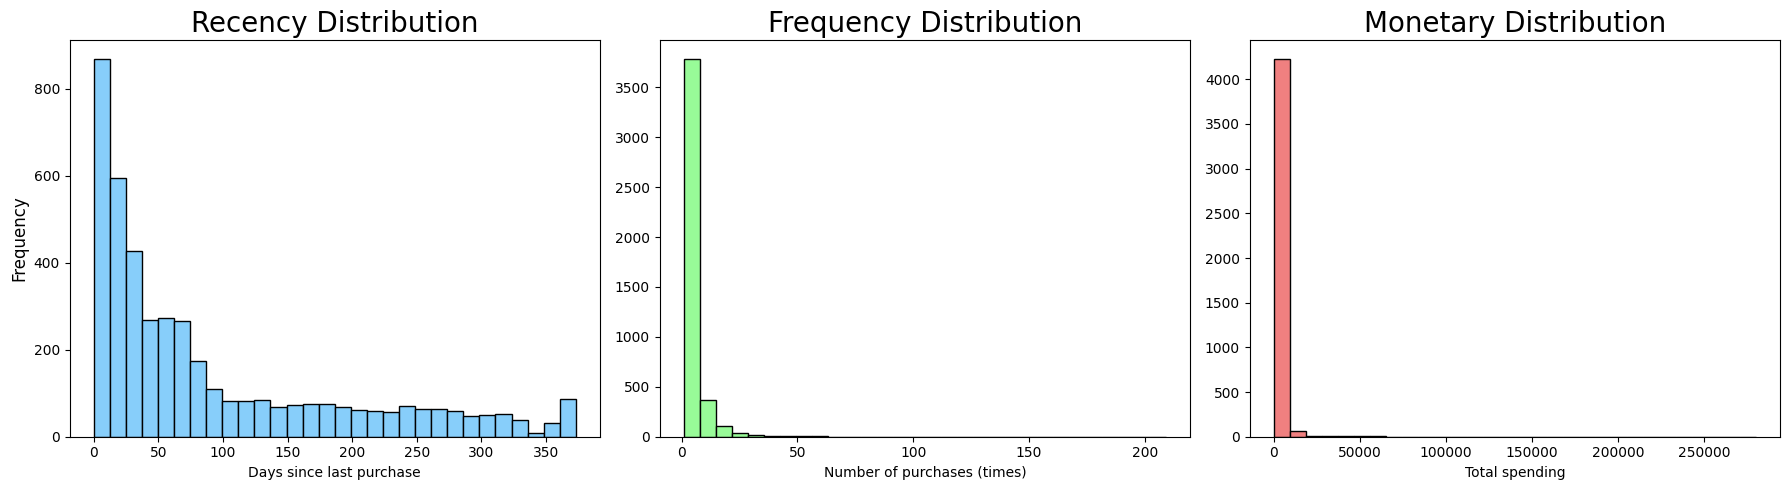

In [14]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 5))

# Recency Histogram
axes[0].hist(final_df['Recency'], bins = 30, color = 'lightskyblue', edgecolor = 'black')
axes[0].set_title('Recency Distribution', fontsize = 20)
axes[0].set_xlabel('Days since last purchase')
axes[0].set_ylabel('Frequency', fontsize = 12)

# Frequency Histogram
axes[1].hist(final_df['Frequency'], bins = 30, color = 'palegreen', edgecolor = 'black')
axes[1].set_title('Frequency Distribution', fontsize = 20)
axes[1].set_xlabel('Number of purchases (times)')

# Monetary Histogram
axes[2].hist(final_df['Monetary'], bins = 30, color = 'lightcoral', edgecolor = 'black')
axes[2].set_title('Monetary Distribution', fontsize = 20)
axes[2].set_xlabel('Total spending')

plt.tight_layout()
plt.show()

Observamos que la mayoría de los valores están agrupados en valores bajos de los gráficos, es decir, la primera barra del histograma. Se puede observar que tenemos pocos clientes con valores extremadamente altos, estos valores pueden influir en sesgar los datos haciéndonos cometer errores en las estimaciones deseadas.

Para evitar sesgos se recomienda eliminar dichos valores.

In [15]:
# Remove outliers

Q1 = final_df.quantile(0.25)
Q3 = final_df.quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - (IQR * 1.5)
upper_limit = Q3 + (IQR * 1.5)

final_df = final_df[(final_df[final_df.columns] >= lower_limit)
                  & (final_df[final_df.columns] <= upper_limit)]

filtered_df = final_df.dropna()
print(f"Clientes antes de filtrar: {len(final_df)}")
print(f"Clientes después de filtrar: {len(filtered_df)}")


Clientes antes de filtrar: 4338
Clientes después de filtrar: 3710


Se eliminaron 1050 clientes (aproximandamente 24% del total) como outliers extremos en al menos una de las dimensiones RFM, lo que ayuda a estabilizar las métricas sin distorsión de valores atípicos

## Segmentación de datos

En esta sección nos centraremos en realizar la segmentación de los clientes. Primero realizaremos una segmentación general.

Esto para una visión más rápida y general de los clientes además de que con este primer score se construirá un score más detallado.

In [16]:
rfm_df = filtered_df.copy()

rfm_df['RecencyScore'] = pd.qcut(filtered_df['Recency'], 5, labels = [5, 4, 3, 2, 1])
rfm_df['FrequencyScore'] = pd.qcut(filtered_df['Frequency'].rank(method = 'first'), 5, labels = [1, 2, 3, 4, 5])
rfm_df['MonetaryScore'] = pd.qcut(filtered_df['Monetary'], 5, labels = [1, 2, 3, 4, 5])

rfm_df.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore
CustomerID,,,,,,
12348.0,74.0,4.0,1797.24,2,4,5
12349.0,18.0,1.0,1757.55,4,1,5
12350.0,309.0,1.0,334.40,1,1,2
12352.0,35.0,8.0,2506.04,4,5,5
12353.0,203.0,1.0,89.00,1,1,1


Los scores del 1 al 5 se asignan con base en quintiles, de forma que el 20% de los clientes con mejores valores (más recientes, más frecuentes, mayor gasto) obtienen un score de 5. Esta normalización permite comparar y combinar las dimensiones en una escala común.

In [17]:
# Create RFMScore column
r = pd.to_numeric(rfm_df['RecencyScore'])
f = pd.to_numeric(rfm_df['FrequencyScore'])
m = pd.to_numeric(rfm_df['MonetaryScore'])

rfm_df['RFMScore'] = r + f + m



Para la segmentación general sumamos los scores individuales que obtuvimos en el código anterior, esto nos da un score entre 3 y 15. Este número es útil porque resume en una sola métrica el valor global del cliente.


In [18]:
# Create RFMType column
R = rfm_df['RecencyScore'].astype('str')
F = rfm_df['FrequencyScore'].astype('str')
M = rfm_df['MonetaryScore'].astype('str')

rfm_df['RFMType'] = R + F + M

rfm_df.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMScore,RFMType
CustomerID,,,,,,,,
12348.0,74.0,4.0,1797.24,2,4,5,11,245
12349.0,18.0,1.0,1757.55,4,1,5,10,415
12350.0,309.0,1.0,334.40,1,1,2,4,112
12352.0,35.0,8.0,2506.04,4,5,5,14,455
12353.0,203.0,1.0,89.00,1,1,1,3,111


Para el score detallado rfm_df concatenamos los scores individuales obteniendo una cadena de texto de la forma '542'. Cada una de estas combinaciones representa un tipo de cliente único. Esto es útil y se puede utilizar para construir cluster personalizados o diseñar campañas de marketing específicas.

Ahora bien, basados en la segmentación general (entre 3 y 15) realizamos la siguiente segmentación.

* Tier 1 = Clientes con RFM score arriba de 13
* Tier 2 = Clientes con RFM  score entre de 13 y 7
* Tier 3 = Clientes con RFM score debajo de 7.

Con el siguiente código dividimos los clientes en 3 categorías según  su RFMScore

In [19]:
def segmentation(x):
    if x > 13:
        return 1
    elif x <= 13 & x > 6:
        return 2
    else:
        return 3

rfm_df['Group'] = rfm_df['RFMScore'].apply(segmentation)
rfm_df.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMScore,RFMType,Group
CustomerID,,,,,,,,,
12348.0,74.0,4.0,1797.24,2,4,5,11,245,3
12349.0,18.0,1.0,1757.55,4,1,5,10,415,3
12350.0,309.0,1.0,334.40,1,1,2,4,112,3
12352.0,35.0,8.0,2506.04,4,5,5,14,455,1
12353.0,203.0,1.0,89.00,1,1,1,3,111,3


El rango de scores se dividió en tres tramos con base en criterios de negocio: un RFMScore > 13 refleja clientes que consistentemente puntúan alto en todas las dimensiones; entre 7 y 13 son clientes regulares, y <7 son clientes con poco valor actual o histórico.

Ahora visualizamos los 3 grupos a través de gráficos de caja.

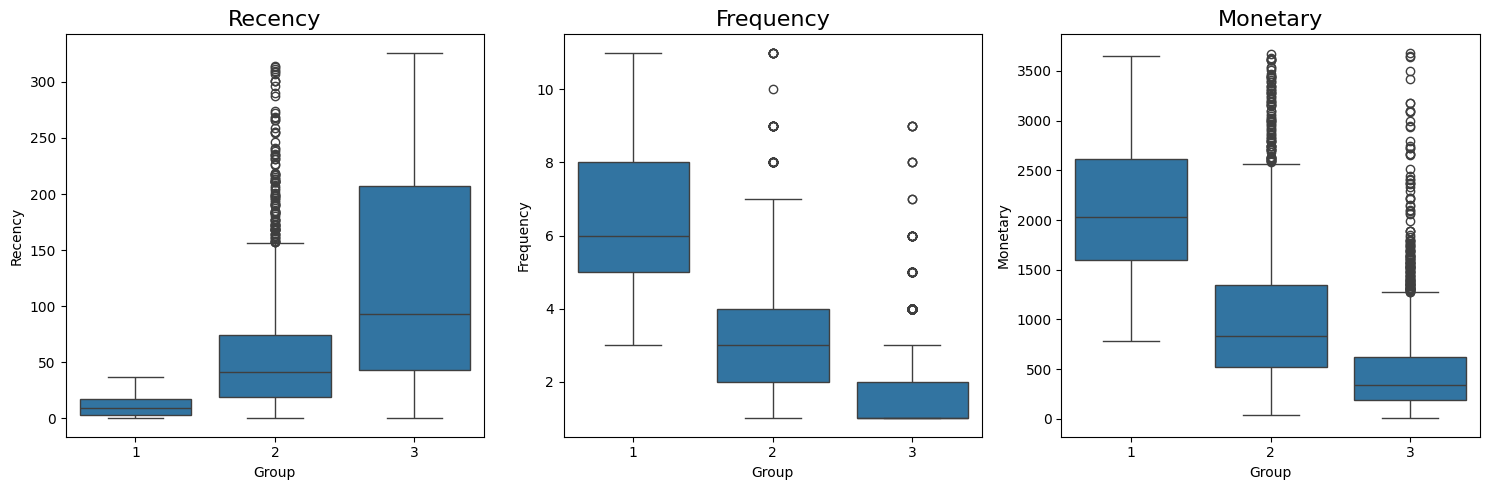

In [20]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))

# Boxplot for Recency
sns.boxplot(x = 'Group', y = 'Recency', data = rfm_df, ax = axs[0])
axs[0].set_title('Recency', fontsize = 16)

# Boxplot for Frequency
sns.boxplot(x = 'Group', y = 'Frequency', data = rfm_df, ax = axs[1])
axs[1].set_title('Frequency', fontsize = 16)

# Boxplot for Monetary
sns.boxplot(x = 'Group', y = 'Monetary', data = rfm_df, ax = axs[2])
axs[2].set_title('Monetary', fontsize = 16)


plt.tight_layout()
plt.show()

El grupo 1 (Tier alto) presenta valores bajos de recency y altos de frequency y monetary, lo cual valida la segmentación propuesta. El grupo 3 muestra alta dispersión en recency y valores bajos en las demás métricas.

## Observaciones finales

**Segmentación Amplia**
La clasificación amplia dividida en 3 secciones usando RFMScore nos ayuda a entender a los clientes en términos de recencia, frecuencia y valor monetario.

* Los clientes del Tier 1 son los más valiosos para la empresa. Se caracterizan por estar altamente comprometidos: compran con frecuencia, lo hacen recientemente y gastan considerablemente más que los demás. Estos clientes tienden a ser leales y satisfechos con el servicio, por lo que deben ser la principal prioridad en las estrategias de retención. Se recomienda recompensarlos con beneficios exclusivos, programas de fidelidad y esfuerzos especiales para mantener su lealtad.

* En el Tier 2 se encuentran clientes que compran con frecuencia moderada, no tan reciente como los del Tier 1, y que también gastan una cantidad razonable. Representan a los compradores regulares y consistentes. Aunque no alcanzan el nivel de compromiso del Tier 1, algunos muestran potencial de crecimiento. La empresa debería enfocarse en incrementar su frecuencia y monto de compra mediante tácticas como ventas cruzadas (cross-selling), ventas adicionales (upselling) e incentivos personalizados. También es útil trabajar su fidelización con promociones específicas.

* Por último, los clientes del Tier 3 son aquellos que compran ocasionalmente, gastan poco y presentan altos valores de recency, lo que indica que han pasado mucho tiempo desde su última compra. Es probable que se trate de compradores estacionales, clientes nuevos o insatisfechos. En este caso, la empresa debe enfocarse en estrategias de reactivación, como campañas de re-engagement, ofertas de bienvenida, descuentos u otros incentivos que ayuden a recuperar su interés y actividad.

Esta segmentación permite a las empresas asignar prioridades, enfocar sus recursos en los clientes con mayor valor y diseñar acciones diferenciadas que aumenten la eficiencia comercial y la satisfacción del cliente.

**Segmentación Detallada**


Mientras que la segmentación amplia agrupa a los clientes en tres niveles generales, la segmentación detallada permite capturar matices más finos del comportamiento y valor del cliente. Aunque existen 125 combinaciones posibles (de 1 a 5 en R, F y M), aquí se enfocan solo en 7 tipos clave y las estrategias recomendadas para cada uno.

* El tipo "555" corresponde a los clientes ideales: son los que han comprado recientemente, con mucha frecuencia y que gastan más. Son el activo más valioso del negocio, por lo que se recomienda priorizarlos con recompensas exclusivas, experiencias personalizadas y programas de fidelización para retenerlos.

* El tipo "x5x" representa a los clientes leales, que compran con frecuencia, aunque quizás no de forma reciente o con el mayor gasto. Son visitantes repetidos con alto potencial de convertirse en clientes ideales. Se sugiere reforzar su relación con beneficios adicionales, programas de lealtad o campañas de advocacy.

* Los "xx5", conocidos como grandes gastadores (Big Spenders), son aquellos que gastan mucho, aunque tal vez no compren tan seguido ni tan recientemente. Están dispuestos a pagar por lo que les gusta, por lo que se recomienda ofrecer productos premium y de alta calidad.

* Los "51x" son nuevos clientes (Newcomers): han comprado muy recientemente, pero no lo hacen con frecuencia. Posiblemente están en su primera compra. Se aconseja darles la bienvenida con correos, ofertas de inicio y explicar los beneficios de los productos o servicios.

* Los "255" se consideran casi perdidos (Almost Lost): dejaron de comprar hace tiempo, pero solían ser clientes frecuentes y de alto gasto. Aunque tienen potencial, están en riesgo de abandono. Por eso, es clave implementar acciones para evitar su pérdida, como mensajes personalizados según su historial de compra.

* El tipo "155", llamado perdido de alto valor (Lost High Value), se refiere a clientes que no compran desde hace mucho, pero que solían gastar mucho. Ya casi no se relacionan con la empresa y probablemente se hayan ido. Requieren campañas de reactivación agresivas, con descuentos o incentivos importantes.

* Finalmente, los "111" son clientes de bajo valor (Lost Low Value): no compran desde hace tiempo, compraron pocas veces y gastaron poco. Su recuperación no es prioritaria, por lo que no conviene dedicar muchos recursos a ellos.



Este análisis permite priorizar a los clientes de mayor valor, optimizar campañas y recursos comerciales, y sentar las bases para futuros modelos de predicción de abandono, recomendación de productos o segmentación más sofisticada con clustering.